In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
from collections import defaultdict

pd.set_option("display.max_rows",10)

## Loading data

In [2]:
train = pd.read_csv('train.csv', sep=',', encoding='utf8')
test = pd.read_csv('test.csv', sep=',', encoding='utf8')
print("Training set shape: {} \nTest set shape: {}".format(train.shape, test.shape))

Training set shape: (159571, 8) 
Test set shape: (153164, 2)


In [3]:
n_train = train.shape[0]
n_test = test.shape[0]

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
# no missing value
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
# Checking statistics of the labels in the training set
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# number of positive examples for each label
pd.DataFrame(train.iloc[:, 2:8].sum()).transpose()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,15294,1595,8449,478,7877,1405


In [8]:
# more detailed count for different toxic comments

labels = train.columns[2:8].tolist()
grp = train.iloc[:,1:8].groupby(labels)

pd.set_option("display.max_rows",50)
print(grp.count())
pd.set_option("display.max_rows",10)

                                                        comment_text
toxic severe_toxic obscene threat insult identity_hate              
0     0            0       0      0      0                    143346
                                         1                        54
                                  1      0                       301
                                         1                        28
                           1      0      0                        22
                                  1      0                         3
                   1       0      0      0                       317
                                         1                         3
                                  1      0                       181
                                         1                        18
                           1      0      0                         2
                                  1      0                         2
1     0            0       0      

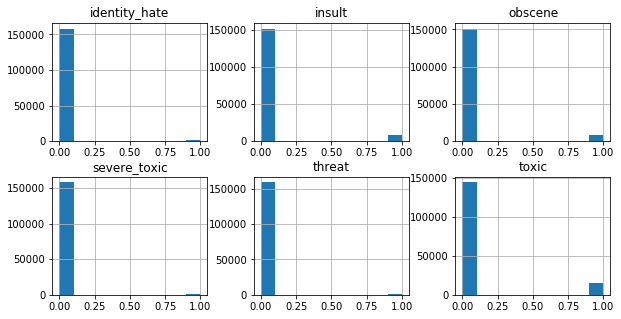

In [9]:
# visuallize the distribution of value for different labels
train.hist(figsize=(10,5), layout=(2,3))
plt.show()

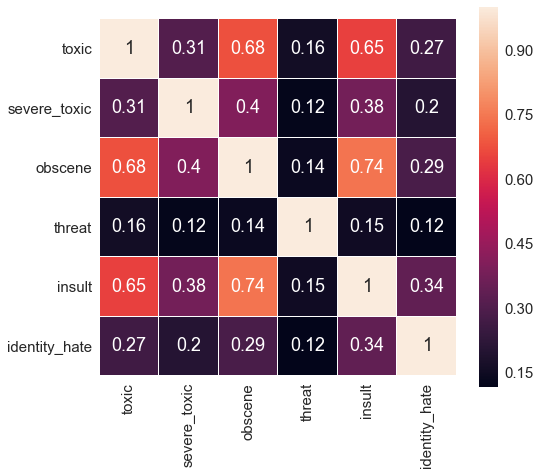

In [10]:
# checking correlation of different lables

plt.figure(figsize=(8,7))
sns.set(font_scale=1.5)
plt.yticks(rotation=0)
sns.heatmap(train.iloc[:,2:].corr(method='spearman'), annot=True, square=True, linewidths=0.1)
plt.show()

<p><a name="textpreprocessing"></a></p>
## Text preprocessing
<div style="text-align: right"> [[back to top]](#table of content) </div>

In [11]:
full_set = pd.concat([train,test], axis=0, ignore_index=True)
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0
1,D'aww! He matches this background colour I'm s...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0
2,"Hey man, I'm really not trying to edit war. It...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0
3,"""\nMore\nI can't make any real suggestions on ...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0
4,"You, sir, are my hero. Any chance you remember...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
312730,". \n i totally agree, this stuff is nothing bu...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN
312731,== Throw from out field to home plate. == \n\n...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN
312732,""" \n\n == Okinotorishima categories == \n\n I ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN
312733,""" \n\n == """"One of the founding nations of the...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import spacy
nlp = spacy.load('en_core_web_lg') 

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [13]:
# update punctuation in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

In [14]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [15]:
def nlp_to_remove(token):
    return(token.is_stop or                                                # remove stop words
           token.is_punct or                                               # reomve punctuations
           token.is_space or                                               # remove white space char
           token.lemma_=='-PRON-'                                          # fixing '-PRON-' issue
           )

def nlp_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in nlp.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not nlp_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
        res['tokenized'].append(lemma_token)                                                  # list of tokens
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # number of char
        res['n_words'].append(m)                                                              # number of words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} min".format(n, (time.time()-start_time)/60))
    return(res)

def token_to_remove(token):    
    return(token.is_punct or 
           token.is_space or 
           token.lemma_.lower() in nlp.Defaults.stop_words                                   # is_stop not working with lg model
           )
    
def token_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in tokenizer.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not token_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
#         res['tokenized'].append([token.lemma_.lower() for token in filtered_tokens])        
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # length of doc
        res['n_words'].append(m)                                                              # number of filtered words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} s".format(n, time.time()-start_time))
    return(res)

def token_combine(nested_list):
    combined_doc = []
    for i in range(len(nested_list)):
        combined_doc.append(' '.join(nested_list[i]))
    return(combined_doc)

In [16]:
%%time

# takes a few minutes to process

if not os.path.exists('full_cleaned.pkl') or 0==1:
    print("start processing text...")
    
    # processing url, ip address and punctuations
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r"(https|http)\S+", "", x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'[0-9]+(\.[0-9]+){3}', 'ipaddress', x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'([{}])'.format(string.punctuation),
                                                                         ' \g<1> ', x))  # “”¨«»®´·º½¾¿¡§£₤‘’
    
#     features = nlp_pip(full_set.comment_text)            # this one takes long time
    features = token_pip(full_set.comment_text)      # this one much faster
    for k in features:
        if k=='cleaned_text':
            full_set[k] = features[k]
        else:
            full_set[k] = features[k]/np.std(features[k])    # normalize
    print('Saving dataframe...')
    full_set.to_pickle('full_cleaned.pkl')
else:
    full_set = pd.read_pickle('full_cleaned.pkl')

Wall time: 2.95 s


In [17]:
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0,0.271503,0.329716,explanation edit username hardcore metallica f...,0.363484,0.458368,0.000000
1,D ' aww ! He matches this background colour I...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0,0.905010,0.299741,d aww match background colour seemingly stick ...,0.244412,0.275021,0.000000
2,"Hey man , I ' m really not trying to edit war...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.329716,hey man try edit war s guy constantly remove r...,0.332149,0.366694,0.000000
3,""" \nMore\nI can ' t make any real suggestions...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.329716,t real suggestion improvement wonder section s...,0.965113,0.898401,0.000000
4,"You , sir , are my hero . Any chance you re...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.239793,sir hero chance remember page s,0.137873,0.110008,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312730,". \n i totally agree , this stuff is nothin...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.209819,totally agree stuff long crap,0.112805,0.091674,0.000000
312731,= = Throw from out field to home plate . ...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.239793,throw field home plate fast throw cut man dire...,0.319615,0.293356,0.000000
312732,""" \n\n = = Okinotorishima categories = ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN,0.484827,0.419638,okinotorishima category change agree correct c...,0.827240,0.513372,0.234331
312733,""" \n\n = = "" "" One of the founding nati...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN,0.301670,0.329716,found nation eu germany law return similar isr...,0.933778,0.825063,0.078110


**check an example**

In [18]:
# example comment in train set before and after processing

idx = list(train.id).index('001956c382006abd')
print(train.comment_text[idx])
print(full_set.cleaned_text[idx])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82
sorry sorry screw someones talk page bad know template talk page help assert dominance know bow almighty administrator play outside mom ipaddress


In [19]:
# example comment in test set before and after processing

idx2 = 999
print(test.comment_text[idx2])
print(full_set.cleaned_text[n_train+idx2])

FAT KID POOPS IN HIDS MOTHERNESS!!!!!!!! FREE SESSION ON LEARNING HOW TO POOP ON TUESDAYS AT THE PARK WITH A KITTEN WITH POOPNESS!!!!!!!!
fat kid poops hids motherness free session learning poop tuesdays park kitten poopness


**Some more EDA**

In [20]:
# number of unique words in train, test and full set. Large amount of non-overlapping words in train and test set

from itertools import chain
full_words = set(chain(*[text.split() for text in full_set.cleaned_text]))
train_words = set(chain(*[text.split() for text in full_set.cleaned_text[:n_train]]))
test_words = set(chain(*[text.split() for text in full_set.cleaned_text[n_train:]]))
common_words = train_words & test_words
print('number of unique words in full set: {}'.format(len(full_words)))
print('number of unique words in train set: {}'.format(len(train_words)))
print('number of unique words in test set: {}'.format(len(test_words)))
print('number of unique words in both train and test set: {}'.format(len(common_words)))

number of unique words in full set: 339501
number of unique words in train set: 173819
number of unique words in test set: 239113
number of unique words in both train and test set: 73431


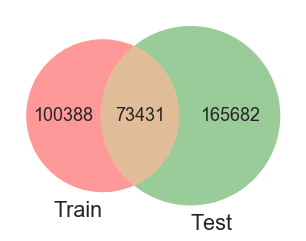

In [21]:
# visuallize the overlapping unique words in train and test set

from matplotlib_venn import venn2

venn2(subsets = (173819-73431, 239113-73431, 73431), set_labels = ('Train', 'Test'))
plt.show()

In [22]:
# Majority of the words in toxic comments are common words also in test set. There are still ~27% words
# in toxic train comments, but not seen in test comments
# using features by tfidf with analyzer='char' should help to reduce this problem

toxic_comments_idx = train.iloc[:,2:8].any(axis=1)
print('Total number of toxic comments in train set: {}'.format(toxic_comments_idx.sum()))
words_in_toxic_comments = set(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text]))
print('Number of words in toxic comments: {}'.format(len(words_in_toxic_comments)))
print('-'*50)
print('Number of common words in toxic comments: {}'.format(len(words_in_toxic_comments & common_words)))
print('Number of train only words in toxic comments: {}'.format(len(words_in_toxic_comments & (train_words - common_words))))

Total number of toxic comments in train set: 16225
Number of words in toxic comments: 30847
--------------------------------------------------
Number of common words in toxic comments: 22285
Number of train only words in toxic comments: 8562


In [23]:
# frequent words in toxic comments:

from collections import Counter
toxic_word_freq = Counter(list(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text])))

In [24]:
toxic_word_freq.most_common(1000)[-50:]

[('oi', 70),
 ('bill', 70),
 ('culture', 69),
 ('male', 69),
 ('advice', 69),
 ('wife', 69),
 ('date', 69),
 ('basically', 69),
 ('angry', 69),
 ('lady', 69),
 ('bestfrozen', 69),
 ('red', 69),
 ('vuvuzelas', 69),
 ('disruptive', 68),
 ('dispute', 68),
 ('gg', 68),
 ('share', 68),
 ('medium', 68),
 ('effort', 68),
 ('offend', 68),
 ('actual', 68),
 ('18', 68),
 ('uncivil', 68),
 ('controversial', 68),
 ('sup', 68),
 ('recent', 67),
 ('islam', 67),
 ('goodbye', 67),
 ('land', 67),
 ('motherfucking', 67),
 ('father', 67),
 ('star', 67),
 ('theory', 67),
 ('multiple', 67),
 ('thousand', 67),
 ('purpose', 67),
 ('figure', 67),
 ('npov', 67),
 ('lead', 67),
 ('position', 67),
 ('team', 67),
 ('vote', 67),
 ('repeatedly', 67),
 ('result', 67),
 ('billj', 67),
 ('lolooolbootstoots', 67),
 ('jump', 66),
 ('neutral', 66),
 ('situation', 66),
 ('honestly', 66)]

In [25]:
# Checking features generated
full_set.iloc[:, 8:].describe()

,caps,longest_word,len_doc,n_words,oov
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,0.349168,0.326700,0.601420,0.574276,0.115535
std,1.000002,1.000002,1.000002,1.000002,1.000002
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.269767,0.150407,0.128343,0.000000
50%,0.000000,0.299741,0.319615,0.293356,0.000000
75%,0.282816,0.359690,0.651765,0.605046,0.078110
max,6.787576,148.521895,62.256054,35.991060,96.153690


In [26]:
# comments that are all uppercase words
full_set[full_set.caps>6]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,0002bcb3da6cb337,0.0,1.0,1.0,1.0,0.0,1.0,6.787576,0.299741,cocksucker piss work,0.050136,0.055004,0.000000
43,"FUCK YOUR FILTHY MOTHER IN THE ASS , DRY !",00190820581d90ce,0.0,1.0,1.0,0.0,0.0,1.0,6.787576,0.179845,fuck filthy mother ass dry,0.068937,0.091674,0.000000
51,GET FUCKED UP . GET FUCKEEED UP . GOT A DRI...,001dc38a83d420cf,0.0,0.0,1.0,0.0,0.0,1.0,6.787576,0.239793,fucked fuckeeed got drink cant fuck fucked m f...,0.263213,0.183347,0.078110
159,""" \n\nUNBLOCK ME OR I ' LL GET MY LAWYERS ON ...",00637960a7ec3436,0.0,0.0,0.0,0.0,0.0,1.0,6.787576,0.419638,unblock ll lawyers blocking constitutional rig...,0.150407,0.146678,0.000000
338,THIS WIIL BE MY LAST USE OF THIS ACOUNT PLEASE...,00d8def7111797e6,0.0,0.0,0.0,0.0,0.0,0.0,6.787576,0.179845,wiil use acount delete,0.094005,0.073339,0.156220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312473,= = YOU SUCK = =,ff8e520038ac36d8,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.119897,suck,0.068937,0.018335,0.000000
312479,NIGEL IS A CRAZY IDIOT ! ! !,ff91c3d8a3e34398,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.149871,nigel crazy idiot,0.062670,0.055004,0.000000
312524,= = CUNT CUNT CUNT CUNT CUNT CUNT = = ...,ffa53a5948abe71d,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.119897,cunt cunt cunt cunt cunt cunt cunt cunt cunt c...,3.039479,7.498902,0.000000
312668,I HATE MILEY CYRUS DDDDDDDDDDDDDD SEE YA SUCKE...,ffe4badc2184252d,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.749354,hate miley cyrus dddddddddddddd ya suckersssss...,0.150407,0.256686,0.234331


In [27]:
# comments that ended up with no token after processing
full_set[full_set.n_words==0]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
627,Seems we both have some .,01ad9cd4eb4a53c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.037602,0.0,0.0
899,I ' ve just seen that,0278c8c0d71aec70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.037602,0.0,0.0
2009,"No , I ' ve not seen anything .",05729c95eb3dc41c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.062670,0.0,0.0
2407,"Here , here and here .",067638a445ccd93b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.043869,0.0,0.0
5198,Who are you showing it to ?,0dd89223c129d0d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.043869,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309172,"Well ( * ^ # & % % ) ( @ # you , ...",fa0b49ac1e36b739,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.238145,0.0,0.0
309212,: This has since been done .,fa1d8cdba2cd3ca1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.050136,0.0,0.0
309519,( ),faa0510471f87cb7,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.025068,0.0,0.0
309847,what about as a last name ?,fb2910e8ce01f045,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.043869,0.0,0.0


In [28]:
# abnormal long word
full_set[full_set.longest_word>100]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
11796,= = U R GAY = = \n\nFUCKFUCKFUCKFUCKFUCKFU...,1f31848ca28571da,1.0,1.0,1.0,1.0,0.0,1.0,6.787576,148.521895,u r gay fuckfuckfuckfuckfuckfuckfuckfuckfuckfu...,0.075204,0.073339,0.078110
34637,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,5c854590da41ac65,0.0,1.0,1.0,0.0,0.0,1.0,2.262525,124.692449,shut cunt wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww...,0.037602,0.055004,0.078110
36097,Death To Wikipedia ! Down with free Speach ! ...,6076128b2bd25f28,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,147.592697,death wikipedia free speach hjyunnnnnnnnnnnnnn...,0.075204,0.091674,0.078110
40851,Discussion destroying CRAP topic \n\nIt seems ...,6d063d8888c30ce7,0.0,0.0,0.0,0.0,0.0,1.0,1.018136,140.938436,discussion destroy crap topic edit topic prope...,0.394819,0.366694,0.078110
90297,I shall purge this web site of the weak ! \n\...,f1a77465fee65775,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,147.652645,shall purge web site weak hyyuyuyuyuyuyuyuyuyu...,0.075204,0.110008,0.078110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115606,Feel the might of Cyber Apocalypse ! \n\nyyyy...,6a4a92c6631e7b90,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,147.802516,feel cyber apocalypse yyyyyyyyyyyyyyybvgtfrrrr...,0.056403,0.073339,0.078110
172779,= = bitch . = = \n\n vgdfut tey ...,16391569cf25129e,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,135.033530,bitch vgdfut tey fsddfsssssssssssssssssdtrdttt...,0.100271,0.073339,0.156220
221482,= = they suck balls = = \n\n v baaaa...,66feb5cc4b40f0e2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,148.222154,suck ball v baaaaaaaaabaaaaaaaaabaaaaaaaaabaaa...,0.100271,0.073339,0.078110
257279,Ï äm̈ ä ẅïk̈ïp̈ëd̈ïä üs̈ër̈ . ̈Ï äm̈ ä ẅïk̈ïp̈...,a308c80d9c7b8d97,NaN,NaN,NaN,NaN,NaN,NaN,1.234105,148.162206,ï äm̈ ä ẅïk̈ïp̈ëd̈ïä üs̈ër̈ ̈ï äm̈ ä ẅïk̈ïp̈ëd...,0.081471,0.201682,0.624882


In [29]:
# abnormal number of oov words
full_set[full_set.oov>20]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
126,"Ahh , Hello Witzeman \n\nipaddress \nSymbols...",00510c3d06745849,0.0,0.0,0.0,0.0,0.0,0.0,1.690222,0.419638,ahh hello witzeman ipaddress symbols ↔ ↑ ↓ ¶ ½...,8.027985,13.989393,24.136060
6572,Sex sex sex sex Sex sex sex sexSex sex sex sex...,118e2e7cd2b30188,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.179845,sex sex sex sex sex sex sex sexsex sex sex sex...,6.273234,18.353057,25.932595
53408,BunkSteve is gay ! BunkSteve is gay ! BunkSt...,8ecc71e2dd4e2fbe,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.269767,bunksteve gay bunksteve gay bunksteve gay bunk...,8.698551,10.194106,21.714643
57594,SuPeRTR0LL WiLL LiVe FoReVeR ! iF You DoN ' T...,9a176c24d63a5c60,0.0,1.0,0.0,0.0,1.0,0.0,0.678758,0.299741,supertr0ll live forever don t respect supertr0...,7.006470,9.350709,23.823619
64020,PenIS pennnis pneis pensnsnnienSNsn peNis PenI...,ab53f74f30338528,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.449612,penis pennnis pneis pensnsnniensnsn penis peni...,3.290158,9.625729,41.007869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311557,= = اشاره ای مجددا به سری دوم مباحثات اصلاح...,fdfab8c744626646,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.329716,اشاره ای مجددا به سری دوم مباحثات اصلاحاتی دست...,6.768325,19.508145,50.068656
311941,= = اتحاد عملکردی اتحاد سیاسی سیر تاملی حل ...,fea1ffc2a9054e21,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.239793,اتحاد عملکردی اتحاد سیاسی سیر تاملی حل بحران ج...,6.981402,20.168195,53.271175
312123,= = PHCK U A $ $ HOLE PHCK U A $ $ HOLE P...,fef08b01324576bf,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.239793,phck u hole phck u hole phck u hole phck u hol...,14.576966,18.206380,26.010706
312133,= = دومین متن مباحثه با موضوع اختصاصی داعش ...,fef5468c148e51d2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.299741,دومین متن مباحثه با موضوع اختصاصی داعش و اسرائ...,6.812194,19.599818,49.131333


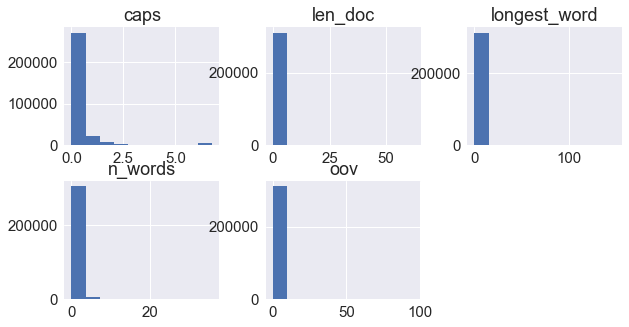

In [30]:
# visuallize the distribution of features
full_set.iloc[:, 8:].hist(figsize=(10,5), layout=(2,3))
plt.show()

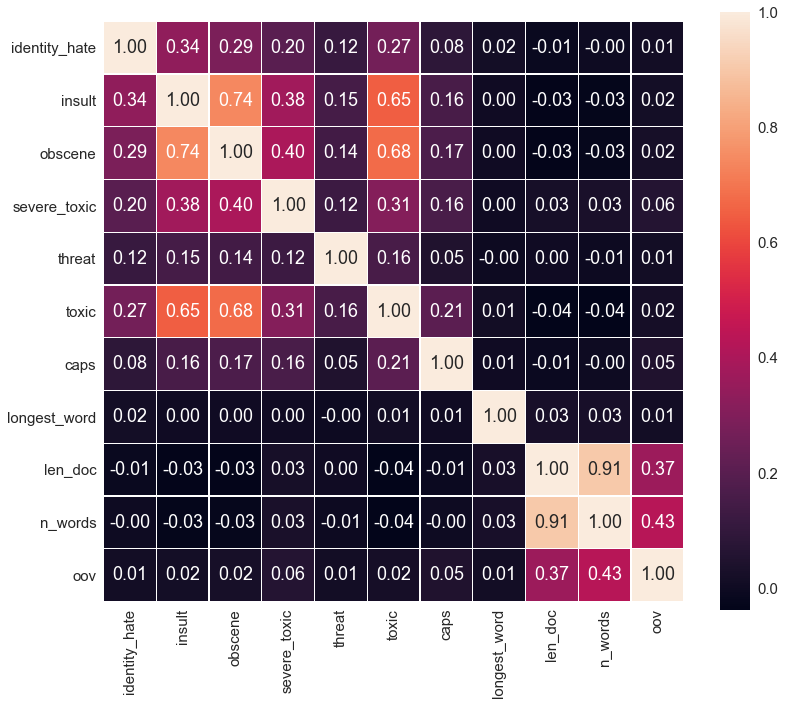

In [31]:
# checking correlation in the train set

plt.figure(figsize=(13,11))
sns.set(font_scale=1.5)
sns.heatmap(full_set.iloc[:n_train,2:].corr(), annot=True, square=True, linewidths=0.1, fmt='.2f')
plt.show()

## using word embeding

- first need to reprocess text, not removing stop words

In [32]:
def token_to_remove(token):    
    return(token.is_punct or 
           token.is_space # or 
           # token.lemma_.lower() in nlp.Defaults.stop_words                                   # is_stop not working with lg model
           )
    
def token_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in tokenizer.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not token_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
#         res['tokenized'].append([token.lemma_.lower() for token in filtered_tokens])        
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # length of doc
        res['n_words'].append(m)                                                              # number of filtered words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} s".format(n, time.time()-start_time))
    return(res)

In [33]:
%%time

# takes a few minutes to process

if not os.path.exists('full_cleaned_sw.pkl') or 0==1:
    print("start processing text...")
    full_set_sw = pd.concat([train,test], axis=0, ignore_index=True)
    # processing url, ip address and punctuations
    full_set_sw.comment_text = full_set_sw.comment_text.apply(lambda x: re.sub(r"(https|http)\S+", "", x))
    full_set_sw.comment_text = full_set_sw.comment_text.apply(lambda x: re.sub(r'[0-9]+(\.[0-9]+){3}', 'ipaddress', x))
    full_set_sw.comment_text = full_set_sw.comment_text.apply(lambda x: re.sub(r'([{}])'.format(string.punctuation),
                                                                         ' \g<1> ', x))  # “”¨«»®´·º½¾¿¡§£₤‘’
    
    features = token_pip(full_set_sw.comment_text)
    for k in features:
        if k=='cleaned_text':
            full_set_sw[k] = features[k]
        else:
            full_set_sw[k] = features[k]/np.std(features[k])    # normalize
    print('Saving dataframe...')
    full_set_sw.to_pickle('full_cleaned_sw.pkl')
else:
    full_set_sw = pd.read_pickle('full_cleaned_sw.pkl')

Wall time: 4 s


In [34]:
idx = list(train.id).index('001956c382006abd')
print(train.comment_text[idx])
print(full_set_sw.cleaned_text[idx])

idx2 = 999
print(test.comment_text[idx2])
print(full_set_sw.cleaned_text[n_train+idx2])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82
i be sorry i be sorry i screw around with someones talk page it be very bad to do i know how have the template on their talk page help you assert your dominance over them i know i should bow down to the almighty administrator but then again i be go to go play outside with your mom ipaddress
FAT KID POOPS IN HIDS MOTHERNESS!!!!!!!! FREE SESSION ON LEARNING HOW TO POOP ON TUESDAYS AT THE PARK WITH A KITTEN WITH POOPNESS!!!!!!!!
fat kid poops in hids motherness free session on learning how to poop on tuesdays at the park with a kitten with poopness


## Word2Vec model

In [35]:
import multiprocessing
from gensim.models import Word2Vec, doc2vec, Doc2Vec

C:\Users\liyadi\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [36]:
assert doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [37]:
class MySentences(object): 
    def __iter__(self):
        for text in full_set_sw.cleaned_text:
            yield text.split()

In [38]:
%%time

cores = multiprocessing.cpu_count()

if not os.path.exists('models/Myword2vec.model') or 0==1:
    print("start traing word2vec model...")
    sentences = MySentences()
    word2vec_model = Word2Vec(sentences, min_count=5, size=300, workers=cores, negative=5, window=5)
    if not os.path.exists('models'):
        os.makedirs('models')
        word2vec_model.save('models/Myword2vec.model')
    else:
        word2vec_model.save('models/Myword2vec.model')
else:
    word2vec_model = Word2Vec.load('models/Myword2vec.model')

Wall time: 2.72 s


In [39]:
word2vec_model.wv.word_vec('fat')

array([-0.62986785,  0.90035379,  0.92187142,  0.63451374,  1.03516209,
        0.56667721, -0.02889404,  0.50108987,  0.45022294,  0.12572996,
        0.12277775,  0.73625278,  0.66869652,  0.36966693,  1.4668932 ,
        0.26365376,  0.46341097, -0.21577294,  0.89870042,  0.56658405,
       -0.61508524, -0.61335135, -0.50820106, -1.09883142,  1.39327121,
        1.06125796,  0.49634683, -0.49469385,  0.1606711 ,  0.09628511,
       -1.44178593, -0.94830042,  1.03851724, -0.68920833, -0.32048383,
        0.3490558 , -0.57345366, -0.53664863,  1.32812381, -0.38178852,
        1.0663904 , -0.09459729, -0.52389783, -0.14254262,  0.4201884 ,
        0.9700498 , -0.69526345, -0.73616415,  0.10051283,  0.93738914,
       -0.14044155, -0.28327048, -1.08880818,  0.82605219, -0.54956234,
       -0.19918643, -1.24786794,  0.12010295, -0.51986527, -0.15915595,
        0.02063912,  0.90439987,  0.54010874, -1.06937766, -0.04381254,
        0.66162777, -1.1865685 ,  1.57620478,  1.07316232, -0.99

In [40]:
word2vec_model.wv.most_similar(positive=['mom'], topn=10)

[('dad', 0.8667240738868713),
 ('mommy', 0.8046636581420898),
 ('boyfriend', 0.8029587864875793),
 ('mum', 0.802200436592102),
 ('girlfriend', 0.7691670656204224),
 ('sister', 0.7467734813690186),
 ('grandmother', 0.7407859563827515),
 ('daddy', 0.7305997610092163),
 ('basement', 0.7250292301177979),
 ('wife', 0.7142705917358398)]

In [41]:
# size of vocabulary
len(word2vec_model.wv.vocab)

59302

In [42]:
%%time
def get_comment_vect(comment_column):
    return(np.array([np.mean([word2vec_model.wv.word_vec(word) 
                              for word in comment.split() if word in word2vec_model.wv.vocab] 
                             or [np.zeros(300)], axis=0) 
                     for comment in comment_column]
                   ))
comment_vect = pd.DataFrame(get_comment_vect(full_set_sw.cleaned_text))

Wall time: 1min 26s


In [43]:
comment_vect

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.364184,0.452900,-0.387562,-0.415856,0.006379,0.559033,-0.310710,-0.012331,0.024087,-0.576084,...,-0.164714,0.055692,0.035730,-0.364544,0.005134,-0.483194,-0.446950,-0.012147,-0.332311,0.489023
1,0.011603,0.055971,0.016059,-0.141248,-0.180623,0.036517,-0.270417,-0.008612,-0.062565,-0.210013,...,-0.078033,0.188009,-0.048226,0.073400,-0.136387,-0.168183,-0.195471,-0.000433,-0.022593,0.022061
2,-0.740097,0.343638,-0.465039,-0.303159,0.002779,0.428781,-0.573854,-0.094993,-0.078708,-0.599514,...,0.006661,0.029643,0.030071,-0.331424,0.059237,-0.888595,-0.484989,-0.171784,-0.542539,-0.052294
3,-0.434668,0.649400,-0.553400,-0.404645,-0.247069,0.354821,-0.416637,-0.216102,-0.301006,-0.522066,...,0.211888,0.082045,-0.232900,-0.285953,0.127415,-0.901864,-0.369421,-0.096774,-0.495365,0.208404
4,-0.838420,0.534680,-0.427061,-0.396859,0.628289,0.770606,-0.766478,-0.316568,0.217085,-0.724190,...,-0.285726,0.251099,-0.364389,-0.744906,-0.301994,-0.819212,-0.406022,0.074858,-0.547422,0.046190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312730,-0.579892,0.425241,-0.460343,0.087601,-0.104745,0.835021,-0.295064,0.097446,0.311633,-0.837787,...,0.286187,0.424213,0.238648,-0.219449,0.038929,-0.866869,0.040232,0.333268,-1.018836,-0.334703
312731,-0.306369,0.577906,-0.267809,0.296479,-0.184786,0.147639,-0.357782,-0.077978,-0.102118,-0.394621,...,0.107180,-0.098938,0.271085,0.190956,0.223355,-0.593752,-0.262186,0.106096,0.096091,-0.273626
312732,-0.362891,0.675760,-0.287103,-0.213250,-0.057149,0.266276,-0.088646,-0.283422,0.025981,-0.449596,...,0.466164,0.129334,-0.230775,-0.273139,-0.053713,-0.916291,-0.378455,-0.052945,-0.475223,-0.004298
312733,-0.588357,0.588382,-0.501670,-0.081754,-0.195936,0.190116,-0.279863,0.132356,-0.060839,-0.759810,...,0.037518,0.060865,-0.110780,-0.096188,0.008414,-0.746704,-0.373432,-0.146338,-0.323925,-0.111489


## Modeling

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import hstack

**parameters: max_df, min_df, ngrame_range, max_features**

In [ ]:
%%time

# Takes few minutes to process
word_tfidf = TfidfVectorizer(analyzer='word', max_df=0.2, min_df=0.0001)
x_word = word_tfidf.fit_transform(full_set.cleaned_text)
char_tfidf = TfidfVectorizer(analyzer='char', max_df=0.15, min_df=0.0003, ngram_range=(1,5), max_features=40000)
x_char = char_tfidf.fit_transform(full_set.cleaned_text)
print(x_word.shape, x_char.shape)

In [ ]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set['toxic'][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set['toxic'][:n_train])

In [ ]:
weight = [1, 0.25]
x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
x_train_comb

<p><a name="mnb"></a></p>
## Multinomial Naive Bayes
<div style="text-align: right"> [[back to top]](#table of content) </div>

In [ ]:
%%time

# try on a single label
# use 1:0.3 joined word char features better than 1:1 for toxic label
mnb = MultinomialNB()
parameters = {'alpha': (1, 0.6, 0.4, 0.2, 0.1)}
nb_toxic = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
nb_toxic.fit(x_train_comb, y_train)
print(nb_toxic.best_params_)
print(nb_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, nb_toxic.predict_proba(x_train_comb)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, nb_toxic.predict_proba(x_test_comb)[:,1])))

### multi label models

In [ ]:
%%time

mnb_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
mnb_submission = pd.read_csv('sample_submission.csv')
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    weight = [1, 0.3]
    x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
    x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
    x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
    mnb = MultinomialNB()
    parameters = {'alpha': (0.2, 0.15, 0.1, 0.05, 0.03)}
    mnb_cv = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', cv=5)
    mnb_cv.fit(x_train_comb, y_train)
    mnb_records.loc[label,'best_params'] = str(mnb_cv.best_params_)
    mnb_records.loc[label,'cv_score'] = mnb_cv.best_score_
    mnb_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, mnb_cv.predict_proba(x_train_comb)[:,1])
    mnb_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, mnb_cv.predict_proba(x_test_comb)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*mnb_records.loc[label]))
    mnb.set_params(**mnb_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    mnb.fit(hstack([x_word[:n_train]*weight[0], x_char[:n_train]*weight[1]]), full_set[label][:n_train])
    mnb_submission[label] = mnb.predict_proba(hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]]))[:,1]
    

In [ ]:
mnb_records

In [ ]:
mnb_records.iloc[:,1:].mean()

In [ ]:
mnb_submission.to_csv('mnb_submission.csv',index=False)

# mnb: 
- using weight(1, 0.3) to join word and char features better than 1:1 join

{'alpha': 0.2}
0.953085464608997
Training score(roc_auc): 0.9642777587057523
Test score(roc_auc): 0.9572685514517963

0.2  0.05  0.15 0.03 0.1 0.05

cv_score       0.962351
train_score    0.980075
test_score     0.964431

kaggle score: 0.9555

## with pipline single label

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(full_set.cleaned_text[:n_train], 
                                                    full_set['toxic'][:n_train], 
                                                    test_size = 0.2, 
                                                    stratify = full_set['toxic'][:n_train])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [ ]:
%%time
# just word features
parameters = {'tfidf__max_df': [0.2],\
              'tfidf__min_df': [0.0001],\
              'nb__alpha': [0.4]
             }
mnb_word_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
mnb_word_toxic.fit(x_train, y_train)
print(mnb_word_toxic.best_params_)
print(mnb_word_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, mnb_word_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, mnb_word_toxic.predict_proba(x_test)[:,1])))

{'nb__alpha': 0.4, 'tfidf__max_df': 0.4, 'tfidf__min_df': 20}
0.9548802633829122

{'nb__alpha': 0.6, 'tfidf__max_df': 0.3, 'tfidf__min_df': 0.0003}
0.9546047253386121

{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
0.955109427915134

In [ ]:
%%time
# just char features
parameters = {'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.15],\
              'tfidf__min_df': [0.0003],\
              'tfidf__ngram_range': [(1,5)],\
              'tfidf__max_features': [40000],\
              'nb__alpha': [0.4]}
mnb_char_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=5)
mnb_char_toxic.fit(x_train, y_train)
print(mnb_char_toxic.best_params_)
print(mnb_char_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, mnb_char_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, mnb_char_toxic.predict_proba(x_test)[:,1])))

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 30000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 4)}
0.939792906316925
Training score(roc_auc): 0.9461465635299896
Test score(roc_auc): 0.941953299598244
Wall time: 4h 30min 5s

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 30000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 5)}
0.9431876996662475
Training score(roc_auc): 0.9487234081778911
Test score(roc_auc): 0.9449681911864919
Wall time: 23min 2s

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
0.9443888224165012
Training score(roc_auc): 0.9513343689715263
Test score(roc_auc): 0.9467136326762108
Wall time: 5h 46min 39s

## with pipeline+Featureunion single label

In [ ]:
%%time
pip_mnb_union = Pipeline([
           
            # use FeatureUnion to combine features from tfidf and other already generated features
            ('union', FeatureUnion(
                transformer_list=[
                    
                    # pipeline to generate features from comments using tfidf analyzed by word
                    ('tfidf_word', Pipeline([
                        ('tfidf', TfidfVectorizer(analyzer='word'))
                    ])),
                    
                    # pipeline to generate features from comments using tfidf analyzed by char
                    ('tfidf_char', Pipeline([
                        ('tfidf', TfidfVectorizer(analyzer='char'))
                    ]))
                ],    
                transformer_weights={
                    'tfidf_word': 1.0,
                    'tfidf_char': 0.2,
                }
                
            )),
    
            ('nb', MultinomialNB())
            ])

parameters = {'union__tfidf_word__tfidf__max_df': [0.2],\
              'union__tfidf_word__tfidf__min_df': [0.0001],\
              'union__tfidf_char__tfidf__max_df': [0.15],\
              'union__tfidf_char__tfidf__min_df': [0.0003],\
              'union__tfidf_char__tfidf__max_features': [40000],\
              'union__tfidf_char__tfidf__ngram_range': [(1,5)],\
              'nb__alpha': [0.6,0.4,0.2],
              }

union_mnb_cv = GridSearchCV(pip_mnb_union, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=3)
union_mnb_cv.fit(x_train, y_train)
print(union_mnb_cv.best_params_)
print(union_mnb_cv.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, union_mnb_cv.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, union_mnb_cv.predict_proba(x_test)[:,1])))

{'nb__alpha': 0.4, 'union__tfidf_char__tfidf__max_df': 0.15, 'union__tfidf_char__tfidf__max_features': 40000, 'union__tfidf_char__tfidf__min_df': 0.0003, 'union__tfidf_char__tfidf__ngram_range': (1, 5), 'union__tfidf_word__tfidf__max_df': 0.2, 'union__tfidf_word__tfidf__min_df': 0.0001}
0.9526365240927905
Training score(roc_auc): 0.9615181461083318
Test score(roc_auc): 0.9547861593721046

{'nb__alpha': 0.2, 'union__tfidf_char__tfidf__max_df': 0.15, 'union__tfidf_char__tfidf__max_features': 40000, 'union__tfidf_char__tfidf__min_df': 0.0003, 'union__tfidf_char__tfidf__ngram_range': (1, 5), 'union__tfidf_word__tfidf__max_df': 0.2, 'union__tfidf_word__tfidf__min_df': 0.0001}
0.955850195663717
Training score(roc_auc): 0.9689354350879801
Test score(roc_auc): 0.9580927452277831
Wall time: 23min 19s

## simple stacking pipline models with word and char features

In [ ]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, (mnb_word_toxic.predict_proba(x_train)[:,1]*0.8+
                                                                               mnb_char_toxic.predict_proba(x_train)[:,1]*0.2))))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, (mnb_word_toxic.predict_proba(x_test)[:,1]*0.8+
                                                                          mnb_char_toxic.predict_proba(x_test)[:,1]*0.2))))

1:1
Training score(roc_auc): 0.9651714798553057
Test score(roc_auc): 0.9568482298458384

4:1
Training score(roc_auc): 0.9685301647630753
Test score(roc_auc): 0.9589809694527178

## mnb model with tfidf-word, all labels

In [33]:
%%time

word_mnb_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
word_mnb_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    word_mnb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])
    parameters = {'tfidf__max_df': [0.4, 0.2, 0.15],\
                  'tfidf__min_df': [0.0001, 0.0003, 0.003],\
                  'nb__alpha': [0.6, 0.5, 0.4, 0.2]
                 }
    word_mnb_cv = GridSearchCV(word_mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
    word_mnb_cv.fit(x_train, y_train)
    word_mnb_records.loc[label,'best_params'] = str(word_mnb_cv.best_params_)
    word_mnb_records.loc[label,'cv_score'] = word_mnb_cv.best_score_
    word_mnb_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, word_mnb_cv.predict_proba(x_train)[:,1])
    word_mnb_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, word_mnb_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*word_mnb_records.loc[label]))
    word_mnb.set_params(**word_mnb_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    word_mnb.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    word_mnb_full[label] = word_mnb.predict_proba(full_set.cleaned_text)[:,1]

Start training classifier on toxic label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 15.5min finished


Best params: {'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}, cv_score: 0.9550078827130518, train_score: 0.9679276328979506, test_score: 0.9596303256634855
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 14.2min finished


Best params: {'nb__alpha': 0.2, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}, cv_score: 0.9789676614405037, train_score: 0.9883241955519528, test_score: 0.9772268899559129
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 13.9min finished


Best params: {'nb__alpha': 0.6, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}, cv_score: 0.9657177130254938, train_score: 0.9733249942525654, test_score: 0.9642367549101658
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 13.9min finished


Best params: {'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.003}, cv_score: 0.9697533098478018, train_score: 0.9853950030058413, test_score: 0.9615744851084782
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 13.7min finished


Best params: {'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}, cv_score: 0.9612750237601925, train_score: 0.9712145235929304, test_score: 0.9640399284301722
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 13.6min finished


Best params: {'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0003}, cv_score: 0.9625447197861673, train_score: 0.9818428366846956, test_score: 0.9723479872212811
Fitting final model and making prediction for submission on identity_hate label
Wall time: 1h 34min 16s


In [34]:
print(*word_mnb_records.best_params, sep='\n')
print(word_mnb_records.iloc[:,1:])
print(word_mnb_records.iloc[:,1:].mean())

{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.6, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.003}
{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0003}
               cv_score train_score test_score
toxic          0.955008    0.967928    0.95963
severe_toxic   0.978968    0.988324   0.977227
obscene        0.965718    0.973325   0.964237
threat         0.969753    0.985395   0.961574
insult         0.961275    0.971215    0.96404
identity_hate  0.962545    0.981843   0.972348
cv_score       0.965544
train_score    0.978005
test_score     0.966509
dtype: float64


{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.5, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.003}
{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}
{'nb__alpha': 0.2, 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0003}
               cv_score train_score test_score
toxic          0.955008    0.967928    0.95963
severe_toxic   0.978968    0.988324   0.977227
obscene         0.96566    0.973624   0.964084
threat         0.969753    0.985395   0.961574
insult         0.961275    0.971215    0.96404
identity_hate  0.962545    0.981843   0.972348
cv_score       0.965535
train_score    0.978055
test_score     0.966484
dtype: float64

In [36]:
word_mnb_full.to_csv('word_mnb_full.csv',index=False)
word_mnb_records.to_csv('word_mnb_records.csv',index=True)

                  'tfidf__max_df': [0.4, 0.3, 0.2, 0.15],\
                  'tfidf__min_df': [0.0001, 0.0003, 0.001, 0.003],\
                  'nb__alpha': [0.6, 0.5, 0.4, 0.2, 0.1]
                  

## mnb model with tfidf-char, all labels ---very time consuming to fine tune

In [45]:
%%time

char_mnb_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
char_mnb_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    char_mnb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])
    parameters = {'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.15, 0.12],\
              'tfidf__min_df': [0.0003],\
              'tfidf__ngram_range': [(1,5)],\
              'tfidf__max_features': [40000],\
              'nb__alpha': [0.4, 0.2]}
    char_mnb_cv = GridSearchCV(char_mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=3)
    char_mnb_cv.fit(x_train, y_train)
    char_mnb_records.loc[label,'best_params'] = str(char_mnb_cv.best_params_)
    char_mnb_records.loc[label,'cv_score'] = char_mnb_cv.best_score_
    char_mnb_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, char_mnb_cv.predict_proba(x_train)[:,1])
    char_mnb_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, char_mnb_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*char_mnb_records.loc[label]))
    char_mnb.set_params(**char_mnb_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    char_mnb.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    char_mnb_full[label] = char_mnb.predict_proba(full_set.cleaned_text)[:,1]

Start training classifier on toxic label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 19.2min finished


Best params: {'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9438663617735209, train_score: 0.9513621686238408, test_score: 0.947215629356778
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.0min finished


Best params: {'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9810017332462886, train_score: 0.9877322633982899, test_score: 0.9796894551550314
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 21.0min finished


Best params: {'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9616746624720707, train_score: 0.9677143459412112, test_score: 0.9615631971260908
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 21.0min finished


Best params: {'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9491728837908645, train_score: 0.9793309125622283, test_score: 0.9514403409388522
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 18.0min finished


Best params: {'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9555089673517058, train_score: 0.9635760462895477, test_score: 0.9627183245963734
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 19.2min finished


Best params: {'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9625542433104942, train_score: 0.9789429647042994, test_score: 0.970552315777182
Fitting final model and making prediction for submission on identity_hate label
Wall time: 2h 58min 1s


In [46]:
print(*char_mnb_records.best_params, sep='\n')
print(char_mnb_records.iloc[:,1:])
print(char_mnb_records.iloc[:,1:].mean())

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.12, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
               cv_score train_score test_score
toxic          0.943866    0.

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
               cv_score train_score test_score
toxic          0.943866    0.951362   0.947216
severe_toxic   0.981002    0.987732   0.979689
obscene        0.961675    0.967714   0.961563
threat         0.948283    0.978424   0.950496
insult         0.955456    0.963371   0.962704
identity_hate  0.962063    0.978343   0.970227
cv_score       0.958724
train_score    0.971158
test_score     0.961983

{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'nb__alpha': 0.2, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
               cv_score train_score test_score
toxic          0.943409    0.956741   0.948965
severe_toxic   0.973072    0.985497   0.973623
obscene        0.958114    0.969775    0.95988
threat         0.912432    0.962793   0.919866
insult         0.952491    0.966795   0.961544
identity_hate  0.940987    0.970586   0.954784
cv_score       0.946751
train_score    0.968698
test_score     0.953111

              'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.3, 0.2, 0.15],\
              'tfidf__min_df': [0.0001, 0.0003],\
              'tfidf__ngram_range': [(1,5)],\
              'tfidf__max_features': [40000],\
              'nb__alpha': [0.6, 0.4, 0.2]}

In [47]:
char_mnb_full.to_csv('char_mnb_full.csv',index=False)
char_mnb_records.to_csv('char_mnb_records.csv', index=True)

<p><a name="lg"></a></p>
## Logistic Regression
<div style="text-align: right"> [[back to top]](#table of content) </div>

In [ ]:
%%time

# use 1:1 joined word char features
lg = LogisticRegression()
parameters = {'C': [0.03, 0.1, 0.3, 0.9],\
             'class_weight': ['balanced'],\
             'solver': ['lbfgs'],\
             }
lg_toxic = GridSearchCV(lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=5)
lg_toxic.fit(x_train_comb, y_train)
print(lg_toxic.best_params_)
print(lg_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, lg_toxic.predict_proba(x_train_comb)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, lg_toxic.predict_proba(x_test_comb)[:,1])))

### multi label models

In [ ]:
%%time

lg_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
lg_submission = pd.read_csv('sample_submission.csv')
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    weight = [1, 1]
    x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
    x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
    x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
    lg = LogisticRegression()
    parameters = {'C': [0.1, 0.2, 0.4, 0.8],\
                  'class_weight': ['balanced'],\
                  'solver': ['lbfgs'],\
                 }
    lg_cv = GridSearchCV(lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
    lg_cv.fit(x_train_comb, y_train)
    lg_records.loc[label,'best_params'] = str(lg_cv.best_params_)
    lg_records.loc[label,'cv_score'] = lg_cv.best_score_
    lg_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, lg_cv.predict_proba(x_train_comb)[:,1])
    lg_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, lg_cv.predict_proba(x_test_comb)[:,1])
    print('Best params: {}, cv_score: {:.6f}, train_score: {:.6f}, test_score: {:.6f}'.format(*lg_records.loc[label]))
    lg.set_params(**lg_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    lg.fit(hstack([x_word[:n_train]*weight[0], x_char[:n_train]*weight[1]]), full_set[label][:n_train])
    lg_submission[label] = lg.predict_proba(x_sub_comb)[:,1]

In [ ]:
lg_records

In [ ]:
lg_records.iloc[:,1:].mean()

In [ ]:
lg_submission.to_csv('lg_submission.csv',index=False)

# logistic regression
- [1,1] joined word and char features better than [1,0.3] joined features

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.9873947097951655
Training score(roc_auc): 0.993149330451378
Test score(roc_auc): 0.9879700358880396
Wall time: 4min 33s

0.8 0.1 0.4 0.1 0.4 0.2

cv_score       0.981977
train_score    0.994437
test_score     0.982493

kaggle score: 0.9774

## logistic regression model from tfidf-word, all labels

In [34]:
%%time

word_lg_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
word_lg_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    word_lg = Pipeline([('tfidf', TfidfVectorizer()), ('lg', LogisticRegression())])
    parameters = {'tfidf__max_df': [0.5, 0.4, 0.2],\
                  'tfidf__min_df': [0.00005, 0.0001, 0.0002],\
                  'lg__class_weight': ['balanced'],\
                  'lg__solver': ['lbfgs'],\
                  'lg__C': [0.05, 0.1, 0.2, 0.4, 0.8, 1]
                 }
    word_lg_cv = GridSearchCV(word_lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
    word_lg_cv.fit(x_train, y_train)
    word_lg_records.loc[label,'best_params'] = str(word_lg_cv.best_params_)
    word_lg_records.loc[label,'cv_score'] = word_lg_cv.best_score_
    word_lg_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, word_lg_cv.predict_proba(x_train)[:,1])
    word_lg_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, word_lg_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*word_lg_records.loc[label]))
    word_lg.set_params(**word_lg_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    word_lg.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    word_lg_full[label] = word_lg.predict_proba(full_set.cleaned_text)[:,1]

Start training classifier on toxic label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 31.8min finished


Best params: {'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}, cv_score: 0.9686441612554454, train_score: 0.9872585613774817, test_score: 0.9717791800531692
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 31.9min finished


Best params: {'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}, cv_score: 0.9851474552431835, train_score: 0.9917170363946917, test_score: 0.9833844191221379
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 28.9min finished


Best params: {'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}, cv_score: 0.9848137941650619, train_score: 0.9943263376125865, test_score: 0.9831182110502592
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 30.3min finished


Best params: {'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.0001}, cv_score: 0.9811428041068667, train_score: 0.9973667522113111, test_score: 0.9736231038582817
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 29.5min finished


Best params: {'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}, cv_score: 0.9761933842973832, train_score: 0.9889081949539981, test_score: 0.9758932102834541
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 30.6min finished


Best params: {'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}, cv_score: 0.9727445487435387, train_score: 0.9927667679299728, test_score: 0.9790201632236318
Fitting final model and making prediction for submission on identity_hate label
Wall time: 3h 11min 54s


In [35]:
print(*word_lg_records.best_params, sep='\n')
print(word_lg_records.iloc[:,1:])
print(word_lg_records.iloc[:,1:].mean())

{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.0001}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
               cv_score train_score test_score
toxic          0.968644    0.987259   0.971779
severe_toxic   0.985147    0.991717   0.983384
obscene        0.984814    0.994326   0.983118
threat         0.981143    0.997367   0.973623
insult         0.976193    0.988908   0.975893
identity_hate  0.9727

{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001}
               cv_score train_score test_score
toxic           0.96785     0.98584   0.971031
severe_toxic   0.984672    0.991401    0.98346
obscene        0.984222    0.993775   0.981968
threat         0.981143    0.997367   0.973623
insult          0.97526    0.988024   0.975399
identity_hate  0.971298    0.992237   0.978517
cv_score       0.977407
train_score    0.991440
test_score     0.977333
dtype: float64

{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.0001}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5e-05}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5e-05}
               cv_score train_score test_score
toxic          0.968644    0.987259   0.971779
severe_toxic   0.985147    0.991717   0.983384
obscene        0.984814    0.994326   0.983118
threat         0.981143    0.997367   0.973623
insult         0.976193    0.988908   0.975893
identity_hate  0.972745    0.992767    0.97902
cv_score       0.978114
train_score    0.992057
test_score     0.977803

                  'tfidf__max_df': [0.5, 0.4, 0.3, 0.2],\
                  'tfidf__min_df': [0.00005, 0.0001, 0.0002, 0.0003, 0.001, 0.003],\
                  'lg__class_weight': ['balanced'],\
                  'lg__solver': ['lbfgs'],\
                  'lg__C': [0.05, 0.1, 0.2, 0.4, 0.8, 1]

In [43]:
word_lg_full.to_csv('word_lg_full.csv',index=False)
word_lg_records.to_csv('word_lg_records.csv', index=True)

## logistic regression model with tfidf-char, all labels

In [37]:
%%time

char_lg_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
char_lg_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    char_lg = Pipeline([('tfidf', TfidfVectorizer()), ('lg', LogisticRegression())])
    parameters = {'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.4, 0.2],\
              'tfidf__min_df': [0.0001, 0.0003],\
              'tfidf__ngram_range': [(1,5)],\
#               'tfidf__max_features': [40000],\
              'lg__class_weight': ['balanced'],\
              'lg__solver': ['lbfgs'],\
              'lg__C': [0.1, 0.2, 0.4, 0.8, 1]
                 }
    char_lg_cv = GridSearchCV(char_lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=3)
    char_lg_cv.fit(x_train, y_train)
    char_lg_records.loc[label,'best_params'] = str(char_lg_cv.best_params_)
    char_lg_records.loc[label,'cv_score'] = char_lg_cv.best_score_
    char_lg_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, char_lg_cv.predict_proba(x_train)[:,1])
    char_lg_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, char_lg_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*char_lg_records.loc[label]))
    char_lg.set_params(**char_lg_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    char_lg.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    char_lg_full[label] = char_lg.predict_proba(full_set.cleaned_text)[:,1]

Start training classifier on toxic label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 76.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 104.6min finished


Best params: {'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9688033831267864, train_score: 0.9923210747108505, test_score: 0.9725522185757541
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 99.7min finished


Best params: {'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9872511038013121, train_score: 0.993530780682829, test_score: 0.9875079917659509
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 166.8min finished


Best params: {'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9886951396500243, train_score: 0.9973444868645687, test_score: 0.988596326368802
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 111.3min finished


Best params: {'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9761448347308186, train_score: 0.999219692732018, test_score: 0.9760630113558986
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 87.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 123.4min finished


Best params: {'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9778383091315479, train_score: 0.9935849276972556, test_score: 0.9778042816335499
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 87.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 122.9min finished


Best params: {'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}, cv_score: 0.9795780395096644, train_score: 0.9965552579050235, test_score: 0.9858488220588821
Fitting final model and making prediction for submission on identity_hate label
Wall time: 13h 26min 45s


In [38]:
print(*char_lg_records.best_params, sep='\n')
print(char_lg_records.iloc[:,1:])
print(char_lg_records.iloc[:,1:].mean())

{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 

{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.4, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.8, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
               cv_score train_score test_score
toxic          0.967772    0.988358   0.971176
severe_toxic   0.987057    0.992343    0.98716
obscene        0.988175    0.996573   0.988169
threat         0.975422    0.998486   0.976327
insult         0.977073    0.991987   0.977095
identity_hate  0.979267    0.996085   0.985326
cv_score       0.979128
train_score    0.993972
test_score     0.980875
dtype: float64

{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.2, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.4, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 1, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001, 'tfidf__ngram_range': (1, 5)}
{'lg__C': 0.4, 'lg__class_weight': 'balanced', 'lg__solver': 'lbfgs', 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
               cv_score train_score test_score
toxic          0.968803    0.992321   0.972552
severe_toxic   0.987251    0.993531   0.987508
obscene        0.988695    0.997344   0.988596
threat         0.976145     0.99922   0.976063
insult         0.977838    0.993585   0.977804
identity_hate  0.979578    0.996555   0.985849
cv_score       0.979718
train_score    0.995426
test_score     0.981395

              'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.4, 0.2],\
              'tfidf__min_df': [0.0001],\
              'tfidf__ngram_range': [(1,5)],\
              'tfidf__max_features': [40000],\
              'lg__class_weight': ['balanced'],\
              'lg__solver': ['lbfgs'],\
              'lg__C': [0.1, 0.2, 0.4, 0.8]

In [44]:
char_lg_full.to_csv('char_lg_full.csv',index=False)
char_lg_records.to_csv('char_lg_records.csv', index=True)

## logistic regression model with word2vec, all labels

In [114]:
%%time

w2v_lg_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
w2v_lg_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(comment_vect[:n_train], 
                                                        full_set_sw[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set_sw[label][:n_train])
    w2v_lg = LogisticRegression()
    parameters = {'class_weight': ['balanced'],\
                  'solver': ['lbfgs'],\
                  'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
                 }
    w2v_lg_cv = GridSearchCV(w2v_lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=5)
    w2v_lg_cv.fit(x_train, y_train)
    w2v_lg_records.loc[label,'best_params'] = str(w2v_lg_cv.best_params_)
    w2v_lg_records.loc[label,'cv_score'] = w2v_lg_cv.best_score_
    w2v_lg_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, w2v_lg_cv.predict_proba(x_train)[:,1])
    w2v_lg_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, w2v_lg_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*w2v_lg_records.loc[label]))
    w2v_lg.set_params(**w2v_lg_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    w2v_lg.fit(comment_vect[:n_train], full_set_sw[label][:n_train])
    w2v_lg_full[label] = w2v_lg.predict_proba(comment_vect)[:,1]

Start training classifier on toxic label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


Best params: {'C': 0.3, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.9596047524368049, train_score: 0.9621766444419689, test_score: 0.9625495850799717
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


Best params: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.9829759387488306, train_score: 0.9855514617060257, test_score: 0.9818582944311431
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


Best params: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.9716778450816964, train_score: 0.9749443268377088, test_score: 0.9706400418948615
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.8min finished


Best params: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.9775136135931969, train_score: 0.9867680969787161, test_score: 0.9751129762615628
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


Best params: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.9675018756965723, train_score: 0.9705305976921453, test_score: 0.9692536752780653
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min finished


Best params: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.960261719137092, train_score: 0.9681775813986767, test_score: 0.9641517066753486
Fitting final model and making prediction for submission on identity_hate label
Wall time: 19min 26s


In [112]:
print(*w2v_lg_records.best_params, sep='\n')
print(w2v_lg_records.iloc[:,1:])
print(w2v_lg_records.iloc[:,1:].mean())

{'C': 0.3, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
               cv_score train_score test_score
toxic          0.959605    0.962177    0.96255
severe_toxic   0.982976    0.985551   0.981858
obscene        0.971678    0.974944    0.97064
threat         0.977514    0.986768   0.975113
insult         0.967502    0.970531   0.969254
identity_hate  0.960262    0.968178   0.964152
cv_score       0.969923
train_score    0.974691
test_score     0.970594
dtype: float64


word2vec: size=300, window=5
{'C': 0.3, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
               cv_score train_score test_score
toxic          0.959605    0.962177    0.96255
severe_toxic   0.982976    0.985551   0.981858
obscene        0.971678    0.974944    0.97064
threat         0.977514    0.986768   0.975113
insult         0.967502    0.970531   0.969254
identity_hate  0.960262    0.968178   0.964152
cv_score       0.969923
train_score    0.974691
test_score     0.970594

word2vec: size=100, window=3
{'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 10, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
{'C': 0.01, 'class_weight': 'balanced', 'solver': 'lbfgs'}
               cv_score train_score test_score
toxic           0.95375    0.954787   0.957034
severe_toxic     0.9822    0.983757   0.982192
obscene        0.964333    0.965793   0.966064
threat          0.97269    0.979577   0.972365
insult         0.963145    0.964357   0.964598
identity_hate  0.957263    0.961801   0.959968
cv_score       0.965564
train_score    0.968345
test_score     0.967037


In [113]:
w2v_lg_full.to_csv('w2v_lg_full.csv',index=False)
w2v_lg_records.to_csv('w2v_lg_records.csv', index=True)

- create train test sets for stacking

In [170]:
%%time

import ast
w2v_lg_stack_train = pd.DataFrame(np.zeros((n_train, 6)), columns=labels)
w2v_lg_stack_test = pd.read_csv('w2v_lg_full.csv')[n_train:]
w2v_lg_records = pd.read_csv('w2v_lg_records.csv')

for j,label in enumerate(labels):
    print('Start generating out-of-sample predictions on {} label for stacking'.format(label))
    skf = list(StratifiedKFold(full_set_sw[label][:n_train], 5))
    w2v_lg = LogisticRegression(**ast.literal_eval(w2v_lg_records.loc[j, 'best_params']))
    for i,(train, test) in enumerate(skf):
        print("Fold", i+1)
        X_train = comment_vect.iloc[train,:]
        y_train = full_set_sw[label][train]
        X_test = comment_vect.iloc[test,:]
        y_test = full_set_sw[label][test]
        w2v_lg.fit(X_train, y_train)
        w2v_lg_stack_train.iloc[test, j] = w2v_lg.predict_proba(X_test)[:, 1]

Start generating out-of-sample predictions on toxic label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Start generating out-of-sample predictions on severe_toxic label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Start generating out-of-sample predictions on obscene label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Start generating out-of-sample predictions on threat label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Start generating out-of-sample predictions on insult label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Start generating out-of-sample predictions on identity_hate label for stacking
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [176]:
w2v_lg_stack_train.to_csv('w2v_lg_stack_train.csv')
w2v_lg_stack_test.to_csv('w2v_lg_stack_test')

## SVM 

## SVM model from word features, all labels

- too slow using SVC(kernal='linear'), LinearSVC can't predict proba

In [ ]:
%%time

word_svm_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
word_svm_full = pd.DataFrame(index=full_set.index, columns=labels)
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    word_svm = Pipeline([('tfidf', TfidfVectorizer()), ('svm', SVC(kernel='linear'))])
    parameters = {'tfidf__max_df': [0.6, 0.4, 0.2],\
                  'tfidf__min_df': [0.00005, 0.0001],\
                  'svm__C': [0.1, 0.3, 1, 3],\
                  'svm__probability': [True],\
                  'svm__class_weight': ['balanced', None]
                 }
    word_svm_cv = GridSearchCV(word_svm, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
    word_svm_cv.fit(x_train, y_train)
    word_svm_records.loc[label,'best_params'] = str(word_svm_cv.best_params_)
    word_svm_records.loc[label,'cv_score'] = word_svm_cv.best_score_
    word_svm_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, word_svm_cv.predict_proba(x_train)[:,1])
    word_svm_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, word_svm_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*word_svm_records.loc[label]))
    word_svm.set_params(**word_svm_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    word_svm.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    word_svm_full[label] = word_svm.predict_proba(full_set.cleaned_text)[:,1]

Start training classifier on toxic label
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
print(*word_svm_records.best_params, sep='\n')
print(word_svm_records.iloc[:,1:])
print(word_svm_records.iloc[:,1:].mean())

In [ ]:
word_svm_full.to_csv('word_lg_full.csv',index=False)
word_svm_records.to_csv('word_lg_records.csv', index=False)

## Tree 
- slow for tfidf features

In [117]:
import xgboost

In [ ]:
train_df = xgboost.DMatrix(x_train_comb, label = y_train)

In [ ]:
%%time

# use 1:1 joined word char features

param = {'eta':0.3,  # learning_rate
         'silent':0,  # printing running messages
         'objective':'binary:logistic', # logistic regression for binary classification, output probability
         'subsample': 1,  # subsample rows
         'scale_pos_weight': 1, # for balancing the classes         
         'colsample_bytree': 0.2,  # subsample columns
         'gamma': 11, # minimum loss reduction required to make a further partition on a leaf node of the tree
         'max_depth':4,  # maximum depth of a tree, 4-10
         'min_child_weight': 5,  # minimum sum of instance weight (hessian) needed in a child
#          'colsample_bylevel': 1, # subsample ratio of columns for each split, in each level
#          'max_delta_step': 0 # help in logistic regression when class is extremely imbalanced, 1-10
         }
xgb_toxic = xgboost.cv(params=param, dtrain=train_df, num_boost_round=500, nfold=3, metrics='auc',\
                   stratified=True, early_stopping_rounds=50,\
                   verbose_eval=True, seed=2018)

# print(lg_toxic.best_params_)
# print(lg_toxic.best_score_)
# print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, lg_toxic.predict_proba(x_train_comb)[:,1])))
# print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, lg_toxic.predict_proba(x_test_comb)[:,1])))

- best auc:
[231]	train-auc:0.983466+0.000306972	test-auc:0.962364+0.00119056
[2777]	train-auc:0.984029+0.000176414	test-auc:0.964967+0.00121307

[158]	train-auc:0.983336+0.000192297	test-auc:0.959391+0.000734916
[151]	train-auc:0.983416+0.000487931	test-auc:0.958959+0.000854794

         'eta':0.3, 
         'silent':0,  
         'objective':'binary:logistic', 
         'subsample': 1,  
         'scale_pos_weight': 1,                          9
         'colsample_bytree': 0.2,                        0.3
         'gamma': 11,                                    11
         'max_depth':4,  
         'min_child_weight': 5,                          50
         'colsample_bylevel': 1, 


## xgboost with word2vec

In [115]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(comment_vect[:n_train], 
                                                    full_set_sw['toxic'][:n_train], 
                                                    np.arange(n_train),
                                                    test_size = 0.2, 
                                                    random_state=2018,
                                                    stratify = full_set_sw['toxic'][:n_train])

In [118]:
train_df = xgboost.DMatrix(x_train, label = y_train)

In [133]:
%%time

param = {'eta':0.3,  # learning_rate
         'silent':0,  # printing running messages
         'objective':'binary:logistic', # logistic regression for binary classification, output probability
         'subsample': 1,  # subsample rows
         'scale_pos_weight': 1, # for balancing the classes         
         'colsample_bytree': 0.5,  # subsample columns
         'gamma': 3, # minimum loss reduction required to make a further partition on a leaf node of the tree
         'max_depth': 4,  # maximum depth of a tree, 4-10
         'min_child_weight': 6,  # minimum sum of instance weight (hessian) needed in a child
#          'colsample_bylevel': 1, # subsample ratio of columns for each split, in each level
#          'max_delta_step': 0 # help in logistic regression when class is extremely imbalanced, 1-10
         }
xgb_toxic = xgboost.cv(params=param, dtrain=train_df, num_boost_round=200, nfold=3, metrics='auc',\
                   stratified=True, early_stopping_rounds=5,\
                   verbose_eval=True, seed=2018)

[0]	train-auc:0.868187+0.000872263	test-auc:0.862609+0.00194823
[1]	train-auc:0.891631+0.00126283	test-auc:0.885143+0.00229899
[2]	train-auc:0.902786+0.000754947	test-auc:0.895528+0.00108561
[3]	train-auc:0.90896+0.00111809	test-auc:0.901907+0.00130322
[4]	train-auc:0.914854+0.00109227	test-auc:0.907806+0.00238326
[5]	train-auc:0.919297+0.00118623	test-auc:0.91257+0.00129537
[6]	train-auc:0.923548+0.00124324	test-auc:0.916305+0.000597618
[7]	train-auc:0.926631+0.0011966	test-auc:0.918766+0.000533132
[8]	train-auc:0.929523+0.00151898	test-auc:0.921912+0.000424178
[9]	train-auc:0.931896+0.000929377	test-auc:0.92379+0.0015033
[10]	train-auc:0.935091+0.000535518	test-auc:0.926758+0.00165482
[11]	train-auc:0.937314+0.000529107	test-auc:0.928997+0.00181481
[12]	train-auc:0.939667+0.000409986	test-auc:0.930945+0.00170342
[13]	train-auc:0.941504+0.000509453	test-auc:0.93246+0.00170682
[14]	train-auc:0.943414+0.000313965	test-auc:0.93398+0.00188622
[15]	train-auc:0.945237+0.000503866	test-auc:0

[127]	train-auc:0.987666+0.000482545	test-auc:0.956534+0.00152523
[128]	train-auc:0.987803+0.000465534	test-auc:0.956575+0.00154099
[129]	train-auc:0.987917+0.000445081	test-auc:0.956581+0.00149737
[130]	train-auc:0.988056+0.000429637	test-auc:0.956596+0.00144307
[131]	train-auc:0.988191+0.000439101	test-auc:0.956572+0.00147164
[132]	train-auc:0.988315+0.00041995	test-auc:0.956597+0.00148127
[133]	train-auc:0.988457+0.000455529	test-auc:0.956526+0.0015673
[134]	train-auc:0.988562+0.000467349	test-auc:0.956505+0.00150706
[135]	train-auc:0.988661+0.00052519	test-auc:0.956556+0.00145625
[136]	train-auc:0.988792+0.000514413	test-auc:0.95656+0.00146945
Wall time: 4min 8s


[139]	train-auc:0.989307+0.000308653	test-auc:0.956745+0.00145265
[150]	train-auc:0.990554+0.000215784	test-auc:0.956494+0.00180961           0.5


## recycle bin

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key='comment', idx=None):
        self.key = key
        self.idx = idx

    def fit(self, x, y=None):
        return(self)

    def transform(self, data_dict):
        if self.key == 'comment':
            return(data_dict[self.key])
        elif self.key == 'features':
            print('Select {}x{} previous generated feature matrix'.format(len(self.idx), 
                                                                          data_dict[self.key].shape[1]))
            return(data_dict[self.key].iloc[self.idx,:])

class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    input data should contain cleaned comments from both train and test set
    (first n_train samples from train set, the rest from test set), 
    as well as featurs already generated during text preprocessing
    '''
    def __init__(self, n_train=None):
        self.n_train = n_train
        
    def fit(self, x, y=None):
        return(self)

    def transform(self, full_set):
        data = {}
        data['comment'] = full_set.cleaned_text
        data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
        print('Extracted {} comments and {} feature matrix'.format(len(data['comment']), data['features'].shape))
        return(data)

class MyTfidf(BaseEstimator, TransformerMixin):
    def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.idx = idx
        self.analyzer = analyzer
        
    def fit(self, x, y=None):
        return(self)
    
    def transform(self, comments):
        if self.analyzer == 'word':
            ngram_range=(1, 1)
        elif self.analyzer == 'char':
            ngram_range=(1, 4)
        vectorizer = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
                                          max_features=self.max_features, analyzer=self.analyzer,)
        matrix = vectorizer.fit_transform(comments)
        print('Finished tf-idf from {}, shape of generated matrix: {}x{}'.format(self.analyzer, 
                                                                                 len(self.idx), 
                                                                                 matrix.shape[1]))
        return(matrix[self.idx])

In [ ]:
pip = Pipeline([
            # Extract comments and features columns
            ('commentfeature', CommentFeatureExtractor()),
            
            # use FeatureUnion to combine features from tfidf and other already generated features
            ('union', FeatureUnion(
                transformer_list=[
                    
                    # pipeline to generate features from comments using tfidf analyzed by word
                    ('tfidf_word', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='word'))
                    ])),
                    
                    # pipeline to generate features from comments using tfidf analyzed by char
                    ('tfidf_char', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='char'))
                    ])),
                    
                    # get other generated features 
#                     ('other_features', Pipeline([
#                         ('selector', ItemSelector(key='features'))
#                     ]))
                ], 
#                 n_jobs=-1,
                transformer_weights={
                    'tfidf_word': 1.0,
                    'tfidf_char': 1.0,
#                     'other_features': 1.0,
                }
            )),            
            ])

In [ ]:
# takes a few minutes

%%time
parameters = {'commentfeature__n_train': n_train,\
              'union__tfidf_word__tfidf__max_df': 1.0,\
              'union__tfidf_word__tfidf__min_df': 50,\
              'union__tfidf_word__tfidf__idx': train_idx,\
              'union__tfidf_char__tfidf__max_df': 1.0,\
              'union__tfidf_char__tfidf__min_df': 50,\
              'union__tfidf_char__tfidf__idx': train_idx,\
              'union__tfidf_char__tfidf__max_features': 30000,\
#               'union__other_features__selector__idx': train_idx,\
              }
pip.set_params(**parameters)

x_train_comb = pip.transform(full_set.drop(['comment_text', 'id', 
                                            'identity_hate', 'insult', 
                                            'obscene', 'severe_toxic', 
                                            'threat'], axis=1))

In [ ]:
parameters = {'commentfeature__n_train': n_train,\
              'union__tfidf_word__tfidf__max_df': 1.0,\
              'union__tfidf_word__tfidf__min_df': 50,\
              'union__tfidf_word__tfidf__idx': test_idx,\
              'union__tfidf_char__tfidf__max_df': 1.0,\
              'union__tfidf_char__tfidf__min_df': 50,\
              'union__tfidf_char__tfidf__idx': test_idx,\
              'union__tfidf_char__tfidf__max_features': 30000,\
#               'union__other_features__selector__idx': train_idx,\
              }
pip.set_params(**parameters)
x_test_comb = pip.transform(full_set.drop(['comment_text', 'id', 
                                            'identity_hate', 'insult', 
                                            'obscene', 'severe_toxic', 
                                            'threat'], axis=1))

In [ ]:
print(x_train_comb.shape)

Checking a sample

In [ ]:
train_idx[1]

In [ ]:
full_set.iloc[91099,-6:]

In [ ]:
print(x_train_comb[1,-5:])

In [ ]:
mnb = MultinomialNB()

In [ ]:
parameters = {'alpha': (1, 0.25, 0.2, 0.15, 0.1)}
nb_toxic = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)

In [ ]:
nb_toxic.fit(x_train_comb, y_train)

In [ ]:
print(nb_toxic.best_params_)
print(nb_toxic.best_score_)

In [ ]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

In [ ]:
{'alpha': 0.2}
0.9497373584576353

**for one label: toxic**

In [ ]:

# def evaluate_model(clf, actual, predicted):
#     """Scores a model with the created train and test sets."""
#     train_loss = metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1])
#     test_loss = metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
#     matrix = confusion_matrix(actual, predicted)
#     report = metrics.classification_report(actual, predicted, target_names = ['0', '1'])
#     print("Train score:", train_loss)
#     print("Test score:", test_loss)
#     print('Confusion Matrix:\n', matrix)
#     print('Classification report:\n', report)

#     return test_loss

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(full_set.cleaned_text[:n_train], 
                                                    full_set['toxic'][:n_train], 
                                                    test_size = 0.2, 
                                                    stratify = full_set['toxic'][:n_train])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [ ]:
parameters = {'tfidf__max_df': (0.70, 0.80, 0.90, 1.0),\
              'tfidf__min_df': (0, 0.01,0.03,0.1),\
              'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)}
gs_nb_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=10)

In [ ]:
%%time

gs_nb_toxic.fit(x_train, y_train)

In [ ]:
gs_nb_toxic.best_params_

In [ ]:
gs_nb_toxic.best_score_

In [ ]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, gs_nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

In [ ]:
metrics.confusion_matrix(y_test, gs_nb_toxic.predict(x_test))

In [ ]:
a = metrics.roc_curve(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])
plt.plot(a[0],a[1])
plt.show()

**Train multipyl classifiers**

issue:
  - fixed  <s>is_stop dose not work with en_core_web_lg, works with en_core_web_sm</s>  
  - is_oov dose not work with en_core_web_sm, works with en_core_web_lg

notes:
 - keep -PRON-
 - ngrams?
 - vector from en_core_web_lg token?
 - other tokenizer?
 - tfidf with analyzer=char
 
 
 https://mlwave.com/kaggle-ensembling-guide/
 
   

data: 
   - v1. en_core_web_lg, nlp.pip, is_stop dose not work with lg model, http address not removed
   - v2. en_core_web_sm, nlp.pip, stop words removed, http address removed, is_oov dose not work with sm model
   - v3. en_core_web_lg, tokenize.pip http address removed, stop word remove fixed, is_oov working
   - v4. en_core_web_lg, tokenize.pip, processed on full set (train and test set combined)

In [ ]:
# dose not work, x, y need to have same number of rows

# class ItemSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, key='comment', idx=None):
#         self.key = key
#         self.idx = idx

#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, data_dict):
#         if self.key == 'comment':
#             return(data_dict[self.key])
#         elif self.key == 'features':
#             return(data_dict[self.key][self.idx,:])

# class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
#     '''
#     input data should contain a column of cleaned comments from both train and test set
#     (first n_train samples from train set, the rest from test set), 
#     as well as featurs generated from comments ready for training
#     '''
#     def __init__(self, n_train=None):
#         self.n_train = n_train
        
#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, full_set):
#         data = {}
#         data['comment'] = full_set.cleaned_text
#         data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
#         return(data)
    
# class MyTfidf(BaseEstimator, TransformerMixin):
#     def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
#         self.max_df = max_df
#         self.min_df = min_df
#         self.max_features = max_features
#         self.idx = idx
#         self.analyzer = analyzer
        
#     def fit(self, x, y=None):
#         return(self)
    
#     def transform(self, comments):
#         if self.analyzer == 'word':
#             ngram_range=(1, 1)
#         elif self.analyzer == 'char':
#             ngram_range=(1, 4)
#         Vectorizer_word = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
#                                           max_features=self.max_features, analyzer=self.analyzer,)
#         word_vector = Vectorizer_word.fit_transform(comments)
#         return(word_vector[self.idx])

# # pipeline for training multipule classifiers
# pip = Pipeline([
#             # Extract comments and features columns
#             ('commentfeature', CommentFeatureExtractor()),
            
#             # use FeatureUnion to combine features from tfidf and other already generated features
#             ('union', FeatureUnion(
#                 transformer_list=[
                    
#                     # pipeline to generate features from comments using tfidf analyzed by word
#                     ('tfidf_word', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='word'))
#                     ])),
                    
#                     # pipeline to generate features from comments using tfidf analyzed by char
#                     ('tfidf_char', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='char'))
#                     ])),
                    
#                     # get other generated features 
#                     ('other_features', Pipeline([
#                         ('selector', ItemSelector(key='features'))
#                     ]))
#                 ], 
#                 n_jobs=-1,
#                 transformer_weights={
#                     'tfidf_word': 1.0,
#                     'tfidf_char': 1.0,
#                     'other_features': 1.0,
#                 }
#             )),
            
#             # run MNB model on x_train, y_train
#             ('mnb', MultinomialNB())
#             ])

# parameters = {'commentfeature__n_train': [n_train],\
#               'union__tfidf_word__tfidf__max_df': [0.6, 0.7, 0.8, 0.9],\
#               'union__tfidf_word__tfidf__min_df': [0, 10, 30, 100],\
#               'union__tfidf_word__tfidf__idx': [train_idx],\
#               'union__tfidf_char__tfidf__max_df': [1],\
#               'union__tfidf_char__tfidf__min_df': [0],\
#               'union__tfidf_char__tfidf__idx': [train_idx],\
#               'union__other_features__selector__idx': [train_idx],\
#               'nb__alpha': [1, 0.3, 0.1, 0.03, 0.01, 0.003]}
# nb_toxic = GridSearchCV(pip, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1)
# nb_toxic.fit(full_set.drop(['comment_text', 'id', 'identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat'], 
#                            axis=1),
#             y_train)